<a href="https://colab.research.google.com/github/DarkAngel007-design/ai-club-task/blob/main/ser_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_API_TOKEN'] = "KGAT_6907a1bb5a9d428ba02bcd0e92be3ce2"

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
%%bash
cat > ~/.kaggle/kaggle.json << EOF
{
  "username": "token",
  "key": "KGAT_6907a1bb5a9d428ba02bcd0e92be3ce2"
}
EOF

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip ravdess-emotional-speech-audio.zip

Archive:  ravdess-emotional-speech-audio.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(os.listdir("/content"))
print(os.listdir("/content/Actor_01")[:5])

['.config', 'Actor_20', 'Actor_04', 'Actor_22', 'Actor_05', 'ser_cnn_best.keras', 'Actor_07', 'Actor_18', 'Actor_19', 'Actor_06', 'Actor_15', 'Actor_10', 'Actor_17', 'Actor_11', 'Actor_16', 'audio_speech_actors_01-24', 'Actor_09', 'Actor_23', 'Actor_12', 'Actor_24', 'Actor_03', 'Actor_01', 'Actor_21', 'Actor_14', 'Actor_02', 'Actor_08', 'Actor_13', 'ravdess-emotional-speech-audio.zip', 'sample_data']
['03-01-06-01-02-02-01.wav', '03-01-07-01-01-02-01.wav', '03-01-07-02-02-01-01.wav', '03-01-04-01-02-01-01.wav', '03-01-06-02-01-01-01.wav']


File: 03-01-01-01-02-02-01.wav
Waveform shape: (152152,)
Sample rate: 48000
Duration (seconds): 3.1698333333333335


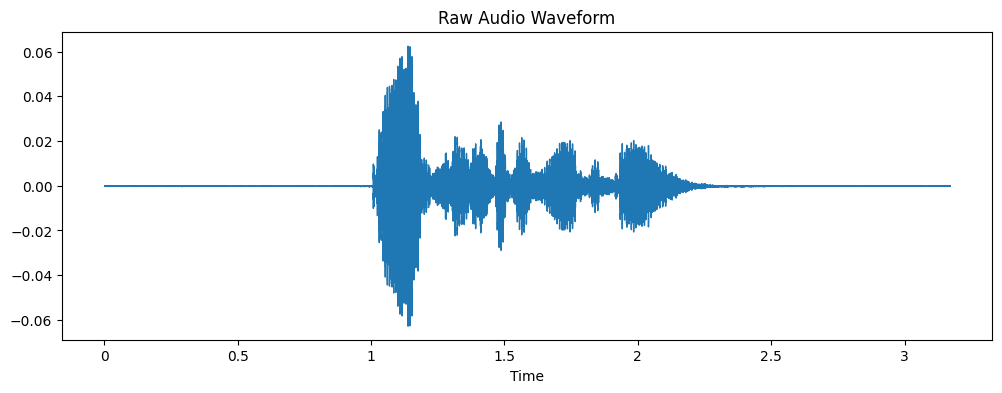

In [ ]:
base_path = "/content"

actor_folder = os.path.join(base_path, "Actor_01")

audio_file = os.listdir(actor_folder)[15]
audio_path = os.path.join(actor_folder, audio_file)

waveform, sample_rate = librosa.load(audio_path, sr=None)

print("File:", audio_file)
print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)

duration = len(waveform) / sample_rate
print("Duration (seconds):", duration)

plt.figure(figsize=(12,4))
librosa.display.waveshow(waveform, sr=sample_rate)
plt.title("Raw Audio Waveform")
plt.show()

Original duration: 3.50s
Trimmed duration: 1.37s


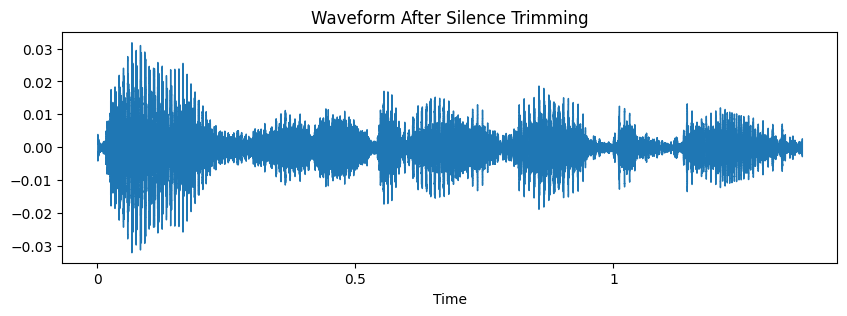

In [ ]:
actor_folder = "/content/Actor_01"
audio_file = os.listdir(actor_folder)[3]
audio_path = os.path.join(actor_folder, audio_file)

waveform, sr = librosa.load(audio_path, sr=None)
trimmed_waveform, _ = librosa.effects.trim(waveform, top_db=20)

print(f"Original duration: {len(waveform)/sr:.2f}s")
print(f"Trimmed duration: {len(trimmed_waveform)/sr:.2f}s")

plt.figure(figsize=(10,3))
librosa.display.waveshow(trimmed_waveform, sr=sr)
plt.title("Waveform After Silence Trimming")
plt.show()


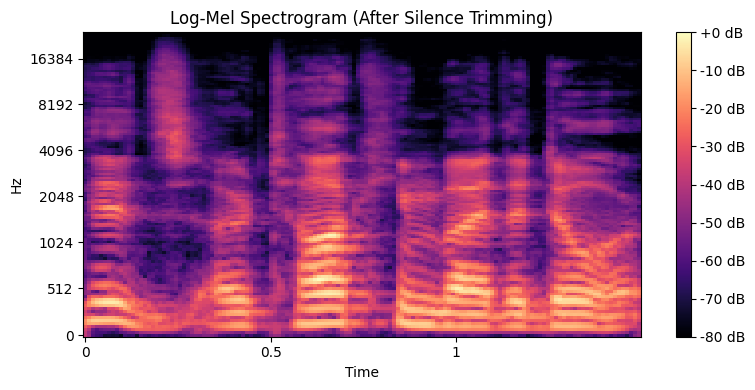

In [ ]:
actor_folder = "/content/Actor_01"
audio_file = os.listdir(actor_folder)[5]
audio_path = os.path.join(actor_folder, audio_file)

audio, sr = librosa.load(audio_path, sr=None)
audio, _ = librosa.effects.trim(audio, top_db=20)

mel = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_mels=128
)

log_mel = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(8,4))
librosa.display.specshow(log_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram (After Silence Trimming)")
plt.tight_layout()
plt.show()

In [ ]:
def pad_or_crop(spec, target_width=128):
    w = spec.shape[1]
    if w < target_width:
        spec = np.pad(spec, ((0,0),(0,target_width-w)), mode='constant')
    else:
        start = (w - target_width) // 2
        spec = spec[:, start:start + target_width]
    return spec

def process_audio(file_path):
    waveform, sr = librosa.load(file_path, sr=None)
    waveform, _ = librosa.effects.trim(waveform, top_db=20)

    mel = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_mels=128
    )

    log_mel = librosa.power_to_db(mel, ref=np.max)
    fixed = pad_or_crop(log_mel)

    return fixed

In [ ]:
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def pitch_shift(audio, sr, steps=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate=rate)

In [ ]:
emotion_map = {
    "01": 0,  # Neutral
    "02": 1,  # Calm
    "03": 2,  # Happy
    "04": 3,  # Sad
    "05": 4,  # Angry
    "06": 5,  # Fearful
    "07": 6,  # Disgust
    "08": 7   # Surprised
}

In [ ]:
X, y, files = [], [], []

for actor_folder in os.listdir("/content"):
    if not actor_folder.startswith("Actor"):
        continue

    for file in os.listdir(os.path.join("/content", actor_folder)):
        if not file.endswith(".wav"):
            continue

        label = emotion_map[file.split("-")[2]]
        path = os.path.join("/content", actor_folder, file)

        spec = process_audio(path)
        X.append(spec)
        y.append(label)
        files.append(file)

        audio, sr = librosa.load(path, sr=None)
        audio, _ = librosa.effects.trim(audio, top_db=20)

        for aug_audio in [
            add_noise(audio),
            pitch_shift(audio, sr, steps=2),
            time_stretch(audio, 1.1)
        ]:
            mel = librosa.feature.melspectrogram(y=aug_audio, sr=sr, n_mels=128)
            log_mel = librosa.power_to_db(mel, ref=np.max)
            fixed = pad_or_crop(log_mel)

            X.append(fixed)
            y.append(label)
            files.append(file)


In [ ]:
X = np.array(X)[..., np.newaxis]
y = np.array(y)
files = np.array(files)

In [ ]:
X_train, X_temp, y_train, y_temp, files_train, files_temp = train_test_split(
    X, y, files, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test, files_val, files_test = train_test_split(
    X_temp, y_temp, files_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [ ]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [ ]:
from tensorflow.keras import layers, models

def build_ser_cnn(input_shape=(128,128,1), num_classes=8):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(256, (3,3), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


model = build_ser_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,864 (788.53 KB)

 Trainable params: 201,160 (785.78 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.1997 - loss: 2.0338 - val_accuracy: 0.1337 - val_loss: 2.3014
Epoch 2/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3164 - loss: 1.8016 - val_accuracy: 0.1337 - val_loss: 2.5610
Epoch 3/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3452 - loss: 1.6952 - val_accuracy: 0.1476 - val_loss: 2.3613
Epoch 4/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3766 - loss: 1.6424 - val_accuracy: 0.2587 - val_loss: 2.0129
Epoch 5/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4016 - loss: 1.5968 - val_accuracy: 0.3872 - val_loss: 1.5907
Epoch 6/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4021 - loss: 1.5628 - val_accuracy: 0.3819 - val_loss: 1.6070
Epoch 7/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4389 - loss: 1.4953 - val_accuracy: 0.4896 - val_loss: 1.4048
Epoch 8/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4413 - loss: 1.4770 - val_acc

In [ ]:
print("Final train acc:", history.history["accuracy"][-1])
print("Final val acc:", history.history["val_accuracy"][-1])

Final train acc: 0.5950520634651184
Final val acc: 0.3177083432674408


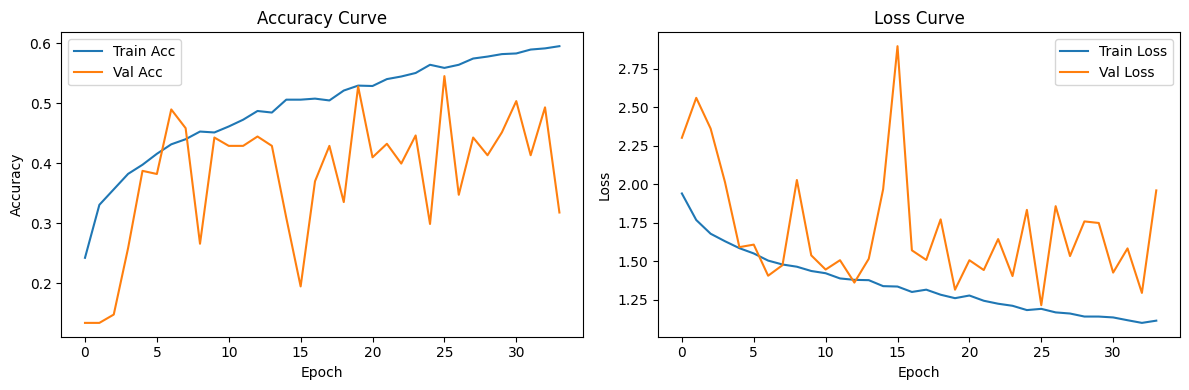

In [ ]:
# Accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.tight_layout()
plt.show()

In [ ]:
model.save("ser_cnn_best.keras")

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.5416666865348816


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)

Macro F1 Score: 0.5086583973254153


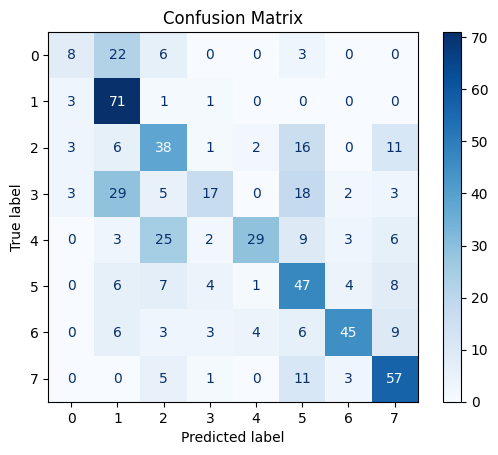

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
X = []
y = []
files = []

BASE_PATH = "/content"
TARGET_WIDTH = 128

for actor_folder in os.listdir(BASE_PATH):
    if not actor_folder.startswith("Actor"):
        continue

    folder_path = os.path.join(BASE_PATH, actor_folder)

    for file in os.listdir(folder_path):
        if not file.endswith(".wav"):
            continue

        emotion_code = file.split("-")[2]
        label = emotion_map[emotion_code]

        file_path = os.path.join(folder_path, file)

        spec = process_audio(file_path)

        X.append(spec)
        y.append(label)
        files.append(file)


X = np.array(X)[..., np.newaxis]
y = np.array(y)
files = np.array(files)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp, files_train, files_temp = train_test_split(
    X, y, files, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test, files_val, files_test = train_test_split(
    X_temp, y_temp, files_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [ ]:
male_correct = []
female_correct = []

for file, pred, true in zip(files_test, y_pred, y_test):
    actor_id = int(file.split("-")[-1].split(".")[0])

    if actor_id % 2 == 0:
        female_correct.append(pred == true)
    else:
        male_correct.append(pred == true)

male_acc = np.mean(male_correct)
female_acc = np.mean(female_correct)

In [26]:
%%writefile predict.py
import sys
import numpy as np
import librosa
import tensorflow as tf

MODEL_PATH = "ser_cnn_best.keras"
TARGET_WIDTH = 128

EMOTION_LABELS = [
    "Neutral",
    "Calm",
    "Happy",
    "Sad",
    "Angry",
    "Fearful",
    "Disgust",
    "Surprised"
]


def pad_or_crop(spec, target_width=128):

    w = spec.shape[1]
    if w < target_width:
        spec = np.pad(spec, ((0, 0), (0, target_width - w)), mode="constant")
    else:
        start = (w - target_width) // 2
        spec = spec[:, start:start + target_width]
    return spec


def preprocess_audio(file_path):
    """Load audio and convert to normalized log-mel spectrogram."""
    audio, sr = librosa.load(file_path, sr=None)
    audio, _ = librosa.effects.trim(audio, top_db=20)

    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=128
    )

    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = pad_or_crop(log_mel)

    log_mel = log_mel[..., np.newaxis]

    return log_mel


def main():
    if len(sys.argv) < 2:
        print("Usage: python predict.py <audio_file.wav>")
        sys.exit(1)

    audio_path = sys.argv[1]

    model = tf.keras.models.load_model(MODEL_PATH)

    spec = preprocess_audio(audio_path)

    spec = (spec - np.mean(spec)) / np.std(spec)

    preds = model.predict(spec[np.newaxis, ...])
    idx = np.argmax(preds)
    confidence = preds[0][idx] * 100

    print(f"Predicted Emotion: {EMOTION_LABELS[idx]}")
    print(f"Confidence: {confidence:.2f}%")


if __name__ == "__main__":
    main()

Overwriting predict.py


In [27]:
!python predict.py Actor_01/03-01-05-01-02-02-01.wav

2026-02-07 19:38:45.590968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770493125.622526   23671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770493125.632312   23671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770493125.663659   23671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770493125.663710   23671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770493125.663719   23671 computation_placer.cc:177] computation placer alr